In [20]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
from imgaug import augmenters as iaa
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam, lr_scheduler
from torchsummary import summary


folder = r'C:\Users\Administrator\Documents\Computer-Vision\fmnist'

train_fmnist = datasets.FashionMNIST(folder, download = True, train=True)
validation_fmnist = datasets.FashionMNIST(folder, download=True, train=False)

image_train, label_train = train_fmnist.data, train_fmnist.targets
image_validation, label_validation = validation_fmnist.data, validation_fmnist.targets

class Data(Dataset):
    def __init__(self, x, y):
        super().__init__()
        x = x.float() / 255
        x = x.view(-1, 1, 28, 28)
        self.x, self.y = x, y
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, ix):
        return self.x[ix], self.y[ix]

def DataLoaders():
    train_dl = DataLoader(Data(image_train, label_train), batch_size = 64, shuffle = True)
    validation_dl = DataLoader(Data(image_validation, label_validation), batch_size = 64, shuffle = True)
    return train_dl, validation_dl

train_dl, validation_dl = DataLoaders()

class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size = 3)
        self.maxp1 = nn.MaxPool2d(2)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(64, 128, kernel_size = 3)
        self.maxp2 = nn.MaxPool2d(2)
        self.relu2 = nn.ReLU()
        self.flat1 = nn.Flatten()
        self.line1 = nn.Linear(3200, 256)
        self.relu3 = nn.ReLU()
        self.line2 = nn.Linear(256, 10)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.maxp1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.maxp2(x)
        x = self.relu2(x)
        x = self.flat1(x)
        x = self.line1(x)
        x = self.relu3(x)
        x = self.line2(x)
        return x

def compile():
    model = Model()
    loss_function = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr = 0.001)
    scheduler = lr_scheduler.ReduceLROnPlateau(optimizer,
                                               factor = 0.5,
                                               patience = 2,
                                               threshold = 0.001,
                                               verbose = True,
                                               min_lr = 0.01,
                                               threshold_mode = 'abs')
    
    return model, loss_function, optimizer, scheduler

model, loss_function, optimizer, scheduler = compile()

def for_training(x, y, model, loss_function, optimizer):
    model.train()
    optimizer.zero_grad()
    predicted = model(x)
    loss = loss_function(predicted, y)
    loss.backward()
    optimizer.step()
    accuracy = (torch.argmax(predicted, dim = 1) == y).float().mean().item()
    return loss.item(), accuracy

def for_validation(x, y, model, validation_dl, loss_function):
    model.eval()
    val_loss, val_accuracy = [], []
    for x, y, in validation_dl:
        prediction = model(x)
        loss = loss_function(prediction, y)
        acc = (torch.argmax(prediction, dim = 1) == y).float().mean().item()
        val_loss.append(loss.item())
        val_accuracy.append(acc)
        return np.mean(val_accuracy), np.mean(val_loss)


epochs = 10
train_loss, train_accuracy = [], []
for epoch in range(10):
    epoch_loss, epoch_accuracy = [], []
    for x, y in train_dl:
        loss, accuracy = for_training(x, y, model, loss_function, optimizer)
        epoch_loss.append(loss)
        epoch_accuracy.append(accuracy)
    train_loss.append(epoch_loss)
    train_accuracy.append(epoch_loss)
    mean_epoch_loss = np.mean(epoch_loss)
    mean_epoch_accuracy = np.mean(epoch_accuracy)
    print(f'epoch {epoch+1}/{epochs} \Train accuracy: {mean_epoch_accuracy} Train_loss: {mean_epoch_loss}')

    with torch.no_grad():
        mean_val_accuracy, mean_val_loss = for_validation(x, y, model, validation_dl, loss_function)
        print(f"Validation accuracy: {mean_val_accuracy} Validation loss: {mean_val_loss}\n")
    scheduler.step(mean_val_loss)

c:\Users\Administrator\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


epoch 1/10 \Train accuracy: 0.831956289978678 Train_loss: 0.4639638466939235
Validation accuracy: 0.921875 Validation loss: 0.20272724330425262

epoch 2/10 \Train accuracy: 0.8903418176972282 Train_loss: 0.29884282636172227
Validation accuracy: 0.890625 Validation loss: 0.31581026315689087

epoch 3/10 \Train accuracy: 0.9087986407249466 Train_loss: 0.24641510113867235
Validation accuracy: 0.96875 Validation loss: 0.13783597946166992

epoch 4/10 \Train accuracy: 0.9198427505330491 Train_loss: 0.214507461916695
Validation accuracy: 0.8125 Validation loss: 0.36876362562179565

epoch 5/10 \Train accuracy: 0.9289045842217484 Train_loss: 0.1883748746506854
Validation accuracy: 0.953125 Validation loss: 0.10095899552106857

epoch 6/10 \Train accuracy: 0.9392490671641791 Train_loss: 0.1635643111518038
Validation accuracy: 0.890625 Validation loss: 0.3209073841571808

epoch 7/10 \Train accuracy: 0.9473947228144989 Train_loss: 0.13960376573103006
Validation accuracy: 0.921875 Validation loss: 0.

In [16]:
from torchsummary import summary

summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 26, 26]             640
         MaxPool2d-2           [-1, 64, 13, 13]               0
              ReLU-3           [-1, 64, 13, 13]               0
            Conv2d-4          [-1, 128, 11, 11]          73,856
         MaxPool2d-5            [-1, 128, 5, 5]               0
              ReLU-6            [-1, 128, 5, 5]               0
           Flatten-7                 [-1, 3200]               0
            Linear-8                  [-1, 256]         819,456
              ReLU-9                  [-1, 256]               0
           Linear-10                   [-1, 10]           2,570
Total params: 896,522
Trainable params: 896,522
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.69
Params size (MB): 3.42
Estimated T

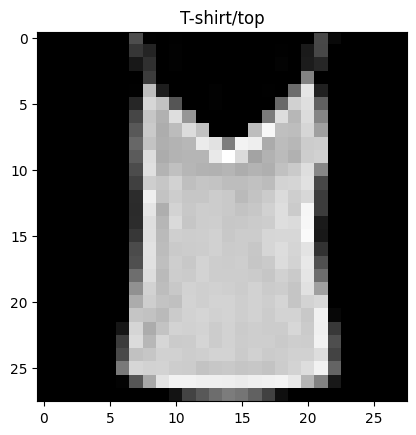

In [93]:
image = 232
img = image_train[image]/255
img = img.view(28, 28)
img2 = np.roll(img, 1, axis = 1)
img3 = torch.Tensor(img2).unsqueeze(0).unsqueeze(0)
predict = model(img3).detach().numpy()
plt.title(validation_fmnist.classes[np.argmax(predict)])
plt.imshow(img, cmap = 'gray')
plt.show()

In [ ]:
from imgaug import augmenters as iaa
import cv2
import matplotlib.pyplot as plt


img = cv2.imread(r'sample121.jpg')
for i in range(1, 11):
    augmenter = iaa.Affine(rotate = i*10, fit_output=False)
    image = augmenter.augment_image(img)
    plt.title(i)
    plt.imshow(image[:, :, ::-1])
    plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Data transformations including augmentation
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Load CIFAR-10 datasets
train_data = datasets.CIFAR10(root=folder, train=True, download=True, transform=transform_train)
test_data = datasets.CIFAR10(root=folder, train=False, download=True, transform=transform_test)

train_loader = DataLoader(train_data, batch_size=128, shuffle=True, num_workers=2)
test_loader = DataLoader(test_data, batch_size=100, shuffle=False, num_workers=2)

# Define CNN model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 16x16

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 8x8

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # 4x4
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.classifier(x)
        return x

# Model, loss, optimizer, and scheduler
model = CNN().cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, factor=0.5, patience=2, verbose=True)

# Training function
def train(model, train_loader, criterion, optimizer):
    model.train()
    total_loss, correct = 0, 0
    for data, target in train_loader:
        data, target = data.cuda(), target.cuda()
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        correct += (output.argmax(dim=1) == target).sum().item()
    return total_loss / len(train_loader), correct / len(train_loader.dataset)

# Testing function
def test(model, test_loader, criterion):
    model.eval()
    total_loss, correct = 0, 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.cuda(), target.cuda()
            output = model(data)
            loss = criterion(output, target)
            total_loss += loss.item()
            correct += (output.argmax(dim=1) == target).sum().item()
    return total_loss / len(test_loader), correct / len(test_loader.dataset)

# Train and evaluate the model
num_epochs = 50
best_acc = 0
early_stop_counter = 0
early_stop_patience = 5

for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_loader, criterion, optimizer)
    test_loss, test_acc = test(model, test_loader, criterion)
    scheduler.step(test_loss)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, '
          f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')

    # Early stopping
    if test_acc > best_acc:
        best_acc = test_acc
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        if early_stop_counter >= early_stop_patience:
            print("Early stopping triggered.")
            break


<h1>Object Detection</h1>

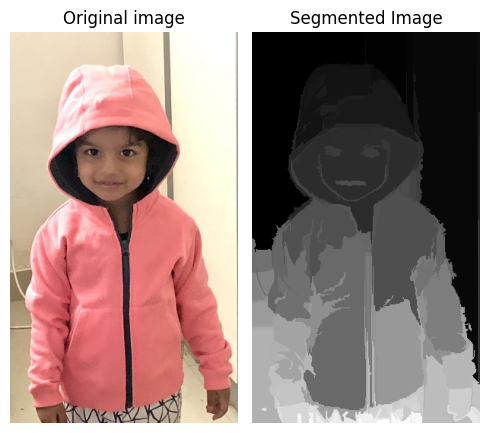

In [2]:
from torch_snippets import *
import selectivesearch
from skimage.segmentation import felzenszwalb
import numpy as np

img = read('Hemanvi.jpeg', 1)
segm = felzenszwalb(img, scale = 200)
subplots(
    [img, segm],
    titles = ['Original image', 'Segmented Image'],
    sz = 5,
    nc = 2
)

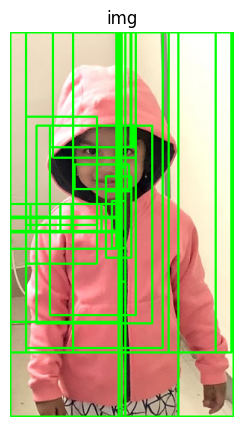

In [25]:
def extract_candidates(img):
    # Fetch the candidate regions within the image using the
    # selective_search method available in the selectivesearch package:
    lbls, regions = selectivesearch.selective_search(img, scale=200, min_size=100)
    
    # Calculate the image area and initialize a list (candidates) that we will
    # use to store the candidates that pass a defined threshold:
    image_area = np.prod(img.shape[:2])
    candidates = []

    # Fetch only those candidates (regions) that are over 5% of the total
    # image area and less than or equal to 100% of the image area and return them:
    for i in regions:
        if i['rect'] in candidates: continue
        if i['size'] < (0.05 * image_area): continue
        if i['size'] > (1 * image_area): continue
        x, y, w, h = i['rect']
        candidates.append(list(i['rect']))
        
    return candidates

# Extract candidates and plot them on top of an image:
candidates = extract_candidates(img)
show(img, bbs = candidates, sz = 5)

In [101]:
def get_iou(boxA, boxB, epsilon = 1e-5) -> any:
    '''
    >>> We define the epsilon parameter to address the rare scenario when the
    union between the two boxes is 0, resulting in a division by zero error. Note
    that in each of the bounding boxes, there will be four values corresponding
    to the four corners of the bounding box.
    
    >>> Note that x1 is storing the maximum value of the left-most x-value between
    the two bounding boxes. Similarly, y1 is storing the topmost y-value and
    x2 and y2 are storing the right-most x-value and bottom-most y-value,
    respectively, corresponding to the intersection part.'''

    x1 = max(boxA[0], boxB[0])
    x2 = max(boxA[1], boxB[1])
    y1 = max(boxA[2], boxB[2])
    y2 = max(boxA[3], boxB[3])

    width = x2 - x1
    height = y2 - y1
    
    if (width<0) or (height<0):
        return 0.0
    
    area_overlap = width * height

    area_a = (boxA[2] - boxA[0] * boxA[3] - boxA[1])
    area_b = (boxB[2] - boxB[0] * boxB[3] - boxB[1])
    combined_area = area_a + area_b - area_overlap
    iou = area_overlap / (combined_area + epsilon)
    return iou

get_iou(candidates[0], candidates[1])

0.0